    Task №2
1. Develop yourself using numpy library: 
a) a function to implement stochastic gradient descent (SGD) algorithm 
b) Adam's optimization algorithm 
for a function of two variables f(x,y).
2. Come up with a function of two variables of an arbitrary form and implement the search for its minimum using those implemented in p.1 functions - a) and b).
3. Illustrate the process of finding an extremum in the form of a graph of the dependence of the value of the difference between two successive approximations of the solution (x_next – x_prev) on the iteration number N.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Data preporation

Let's create some experemental data with some noise to check the implementations of out algorithms.

Following function of two variables was shoosen for optimization:
\begin{equation}
f(x) = a \cdot \sin (x) + b \cdot x
\end{equation}
whith following paramentrs: $a=5$ and $b=1$.



In [2]:
def f(params, x):
    a, b = params
    return a * np.sin(x) + b * x

Following data was generated for experiment:
\begin{equation}
y = f(x) + 2 \cdot N(0, 1)
\end{equation}

In [3]:
np.random.seed(123)
#paraments of the function
a = 5
b = 1

#experimantal data with some noise
x = np.linspace(0, 20, 40)
y = f((a, b), x) + 2*np.random.normal(size=len(x))

#true equation
x_100 = np.linspace(0, 20, 100)
true_y = f((a, b), x_100)

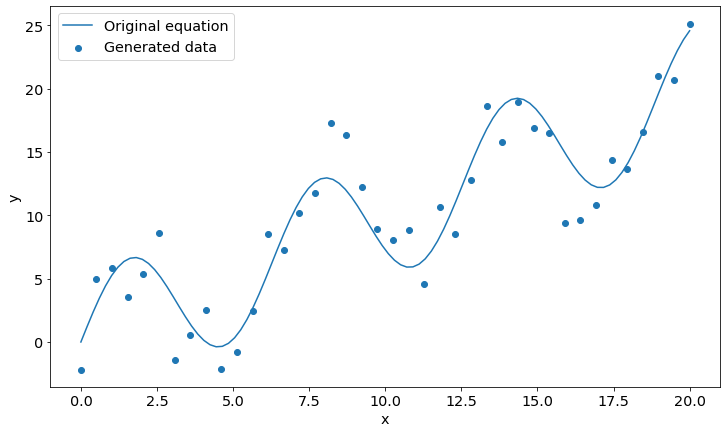

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(x_100, true_y, label='Original equation')
plt.scatter(x, y, label='Generated data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Implementation of SGD and Adam algorithm

As an optimized function we will use MSE, also we need to calculate gradient of MSE to implement SGD.

In [5]:
#gradient of the initial function
def df(params, x):
    a, b = params
    f_a = np.sin(x)
    f_b = x
    return np.array([f_a, f_b])

#MSE
def MSE(params, x, y):
        return np.sum((f(params, x) - y)**2) / len(x)

#gradient of MSE    
def dMSE(params, x, y):
    return 2 * (f(params, x) - y) * df(params, x)
        

#SGD implementation    
def SGD(f, df, params0, X, y, eps=0.0001, nu=0.1, batch_size = 5, max_iter=float('inf')):
    '''
    Parameters
    ----------
    f : function of type f(params, x, y)
        Loss function for which we are searching "params" for a minimum.
    df : function
        Gradient of f(params, x, y).
    params0 : tuple
        Initial guess for a f(params0, x, y).
    eps : number
        Stopping criteria is abs(f(params, x, y)) < epsilon.
    nu : number
        Coeficient for one step.
    batch_size:
        Number of samples, that are taken into consideration during of one step.
    max_iter : integer
        Maximum number of iterations of SGD method.

    Returns
    -------
    params: list
        Oprimized parameters.
    param_list:
        List of optimizing parameters on each step.
    diff:
        Value of the difference between two successive approximations
        of the solution (x_next – x_prev) on each  iteration number.
    error_list:
        Overall MSE error on each iteration number.
    '''
        
    #function that computes gradient over one batch
    def compute_gradient(params):
        grad = 0
        for _ in range(batch_size):
            i = np.random.choice(len(X))
            grad += df(params, X[i], y[i])
        return grad / batch_size
    
    #first step
    params = params0 -  nu * compute_gradient(params0)
    
    #journal
    param_list = [params0, params]
    diff = [np.linalg.norm(params - params0)]
    error_list = [f(params, x, y)]
    
    
    i = 1
    while diff[-1] > eps and i <= max_iter:
        #iteration step
        old_params = params.copy()
        params -= nu * compute_gradient(params)
        i += 1
        
        #journal update
        diff.append(np.linalg.norm(params - old_params))
        param_list.append(params.copy())
        error_list.append(f(params, x, y))
    
    #return answer
    return params, param_list, diff, error_list

During SGD we apply our loss-function on random batch, during Adam optimization we will apply our MSE loss function on all data. So we can simplify our functions for Adam case:

In [6]:
#MSE function
def MSE_adam(params):
    return MSE(params, x, y)

#gradient of MSE function
def dMSE_adam(params):
    return np.mean(dMSE(params, x, y), axis=1)

#Adam algorithm
def Adam(f, df, params0, gamma, lr, b_1=0.9, b_2=0.999, eps=1e-8, nu = 0.0001,  max_iter = float('inf')):
    '''
    Parameters
    ----------
    f : function of type f(params)
        Loss function for which we are searching "params" for a minimum.
    df : function
        Gradient of f(params).
    params0 : tuple
        Initial guess for a f(params0).
    gamma: number
        Cofficient for gradinent correcton.
    lr: number
        Learning rate
    b1: number
        Cofficient  for exponential smoothing.
    b2: number 
        Cofficient  for exponential smoothing.
    eps: number
        Cofficient for weights update
    nu : number
        Stopping criteria is abs(f(params, x, y)) < nu.
    max_iter : integer
        Maximum number of iterations of SGD method.

    Returns
    -------
    params: list
        Oprimized parameters.
    param_list:
        List of optimizing parameters on each step.
    diff:
        Value of the difference between two successive approximations
        of the solution (x_next – x_prev) on each  iteration number.
    error_list:
        Overall MSE error on each iteration number.
    '''
        
    def corr(v, t):
        return v / (1 - gamma**t)
    
    def make_step(params, v, s, t):
        v = b_1 * v + (1 - b_1) * df(params)
        s = b_2 * s + (1 - b_2) * np.linalg.norm(df(params))
        params -= lr / (np.sqrt(corr(s, t)) + eps) * v
        
        return v, s, params
    
    #first step
    v, s = 0, 0
    v, s, params = make_step(params0, v, s, 1)
    
    #jouranl
    param_list = [params0, params]
    diff = [np.linalg.norm(params - params0)]
    error_list = [f(params)]
    
    i = 2
    while diff[-1] > nu and i <= max_iter:
        #iteration step
        old_params = params.copy()
        v, s, params = make_step(params, v, s, i)
        
        #journal update
        param_list.append(params)
        diff.append(np.linalg.norm(params - old_params))
        error_list.append(f(params))
        i += 1
        
    return params, param_list, diff, error_list
    

# Comparison of the results

In [7]:
#calculation of the results
results_SGD = SGD(MSE, dMSE, (2, 0.5), x, y, eps = 0.0001, batch_size=5, nu=0.001, max_iter=1000)
results_adam = Adam(MSE_adam, dMSE_adam, (2, 0.5), gamma=0.5, lr=0.001, max_iter = 1000)

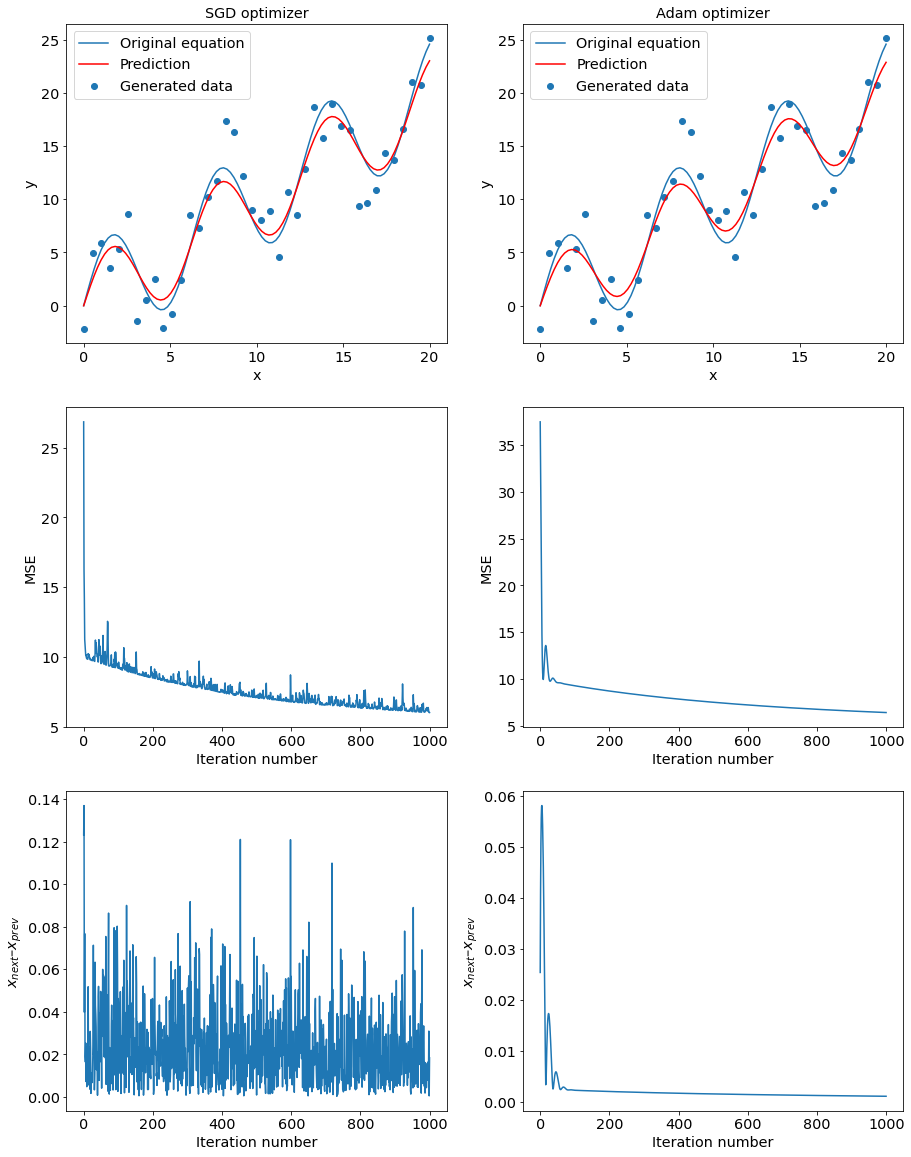

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

axs[0, 0].plot(x_100, true_y, label='Original equation')
axs[0, 0].plot(x_100, f(results_SGD[0], x_100), color='r', label='Prediction')
axs[0, 0].scatter(x, y, label='Generated data')
axs[0, 0].set_title('SGD optimizer')

axs[0, 1].plot(x_100, true_y, label='Original equation')
axs[0, 1].plot(x_100, f(results_adam[0], x_100), color='r', label='Prediction')
axs[0, 1].scatter(x, y, label='Generated data')
axs[0, 1].set_title('Adam optimizer')

for i in range(2):
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('y')
    axs[0, i].legend()

axs[1, 0].plot(results_SGD[-1], label='SGD')
axs[1, 1].plot(results_adam[-1], label='Adam' )
for i in range(2):
    axs[1, i].set_xlabel('Iteration number')
    axs[1, i].set_ylabel('MSE')

axs[2, 0].plot(results_SGD[-2], label='SGD')
axs[2, 1].plot(results_adam[-2], label='Adam' )
for i in range(2):
    axs[2, i].set_xlabel('Iteration number')
    axs[2, i].set_ylabel('$x_{next} – x_{prev}$')


How we can see, behavior of SGD and Adam algorithms differ from each other because of presence stochastic component in SGD. SGD tries to decrease MSE on a batch, but MSE over all data can either increase or decrease. So, we can see some sharp rise on plots of MSE and step differences. But the average value of MSE converges to minimum value. In case of big datasets SGD requires much less computational costs and converges faster than usual GD. While Adam optimizer in our implementation takes all training data inti account to make optimization step, so dependence of MSE and step difference on international number is much smoother, but it requires more computation power to make one optimization step than in case of SGD.